In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import  OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.sql import functions as F, SparkSession
import seaborn as sb
from sklearn.metrics import auc, roc_curve

# Create SparkSession and read CSV file.

In [2]:
spark = SparkSession.builder.appName('Bank Data - Linear SVM').getOrCreate()

In [3]:
df = spark.read.csv('./bankdata.csv', header=True, inferSchema=True)

# Use StringIndexer on categorical variable columns.

In [4]:
# Features that are categorical.
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

In [5]:
# List of indexers to apply to the data.
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in categorical_features]

In [6]:
# Create and apply the indexers.
pipeline = Pipeline(stages=indexers)
indexed_df = pipeline.fit(df).transform(df)

In [7]:
# Drop original columns.
indexed_df = indexed_df.drop('job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome')

# Create sparse vectors of each indexed column.

In [8]:
# List of columns that are indexed.
indexed_cols = ['job_index','marital_index', 'education_index','default_index', 'housing_index', 'loan_index', 'contact_index',
                'month_index', 'poutcome_index']

In [9]:
# Create encoder.
encoder = OneHotEncoderEstimator(inputCols=indexed_cols,
                                 outputCols=[feat + '_sparse' for feat in indexed_cols])

In [10]:
# Fit and apply encoder to dataframe.
model = encoder.fit(indexed_df)
sparse_indexed_df = model.transform(indexed_df)

In [11]:
# Drop non-sparse indexed columns.
sparse_indexed_df = sparse_indexed_df.drop('job_index','marital_index', 'education_index','default_index', 'housing_index',
                                           'loan_index', 'contact_index','month_index', 'poutcome_index')

# Use VectorAssembler to compress all independent variable columns into a dense vector.

In [12]:
# Create list of IVs.
IV_features = ['age', 'balance','day', 'campaign', 'pdays', 'previous', 'housing_index_sparse', 'contact_index_sparse', 
             'job_index_sparse', 'loan_index_sparse', 'marital_index_sparse', 'default_index_sparse', 'month_index_sparse', 
             'education_index_sparse', 'poutcome_index_sparse']

In [13]:
# Create the vector assembler and name the vector column "features".
vec_assembler = VectorAssembler(inputCols=IV_features, outputCol='features')

In [14]:
# Create the new dataframe that has the "features" column of dense vectors..
dense_df = vec_assembler.transform(sparse_indexed_df)

In [15]:
# Create a dataframe consisting only of IV vector and the churn indicator.
processed_df = dense_df.select('features', 'churn')

In [16]:
# Split the data into three categories: training data, testing data, and validation data.
train, test, valid = processed_df.randomSplit([.6, .2, .2])

# Create, train, and predict with Linear SVM model.

In [17]:
# Create Linear SVM model, fit the model to the training data.
model = LinearSVC(labelCol='churn')
model = model.fit(train)

In [18]:
# Get predictions for the testing data and print the accuracy.
test_preds = model.transform(test)

In [19]:
# Get predictions for the validation data and print the accuracy.
valid_preds = model.transform(valid)

# Calculate accuracy scores.

In [20]:
def get_accuracy_score(preds_df):
    return preds_df.filter(preds_df.churn == preds_df.prediction).count() / preds_df.count()

In [21]:
print("Test data prediction accuracy: {0:.3f}".format(get_accuracy_score(test_preds)))
print("Validation data prediction accuracy: {0:.3f}".format(get_accuracy_score(valid_preds)))

Test data prediction accuracy: 0.883
Validation data prediction accuracy: 0.887


# Plot confusion matrices.

## Test dataset.

In [22]:
# Get confusion matrix values.
test_tp = test_preds.filter((test_preds.churn == 1) & (test_preds.prediction == 1)).count()
test_tn = test_preds.filter((test_preds.churn == 0) & (test_preds.prediction == 0)).count()
test_fp = test_preds.filter((test_preds.churn == 0) & (test_preds.prediction == 1)).count()
test_fn = test_preds.filter((test_preds.churn == 1) & (test_preds.prediction == 0)).count()

In [23]:
# Create confusion matrix.
test_cm =[[test_tn, test_fp], [test_fn, test_tp]]

## Validation dataset.

In [24]:
# Get confusion matrix values.
valid_tp = valid_preds.filter((valid_preds.churn == 1) & (valid_preds.prediction == 1)).count()
valid_tn = valid_preds.filter((valid_preds.churn == 0) & (valid_preds.prediction == 0)).count()
valid_fp = valid_preds.filter((valid_preds.churn == 0) & (valid_preds.prediction == 1)).count()
valid_fn = valid_preds.filter((valid_preds.churn == 1) & (valid_preds.prediction == 0)).count()

In [25]:
# Create confusion matrix.
valid_cm =[[valid_tn, valid_fp], [valid_fn, valid_tp]]

## Plot with Seaborn.

In [26]:
# Set the tickmark names.
classNames = ['Negative','Positive']

# Set the text scale for Seaborn.
sb.set(font_scale=1.6)

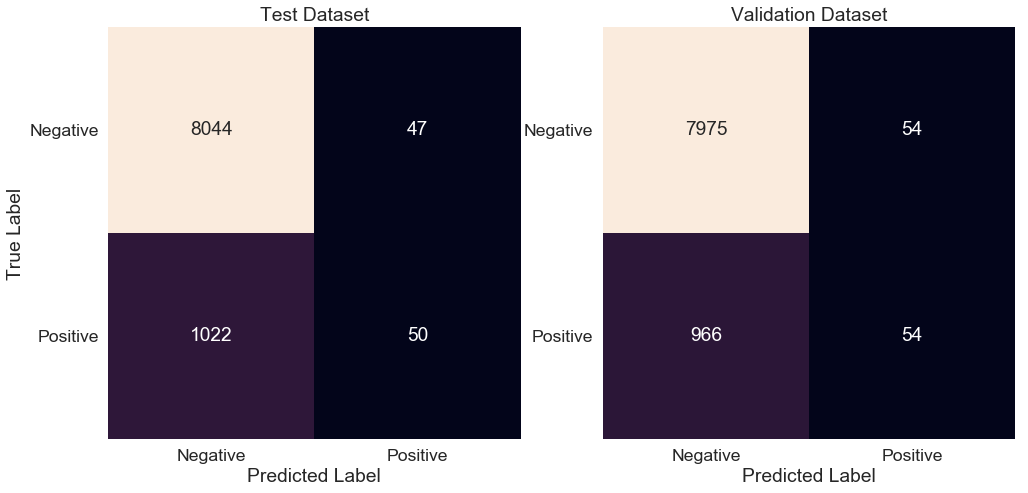

In [27]:
# Set each figure's size.
plt.figure(figsize=(8,8))

#----------
# Test Dataset.
#----------

# Create first subplot.
plt.subplot(1,2,1)

# Set title.
plt.title('Test Dataset')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(test_cm, annot=np.array(test_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x and y axes names.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#----------
# Validation Dataset.
#----------

# Create second subplot.
plt.subplot(1,2,2)

# Set title.
plt.title('Validation Dataset')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(valid_cm, annot=np.array(valid_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x axis name.
plt.xlabel('Predicted Label')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.7)

plt.show()

# Calculate FPR, TPR, and AUC.

## Test dataset.

In [28]:
# Create list of 'churn' column values.
test_churn_list = test_preds.select('churn').collect()
test_churn_list = [test_churn_list[i][0] for i in range(len(test_churn_list))]

In [29]:
# Create list of 'prediction' column values.
test_pred_list = test_preds.select('prediction').collect()
test_pred_list = [test_pred_list[i][0] for i in range(len(test_pred_list))]

In [30]:
# Get FPR, TPR.
test_fpr, test_tpr, test_thresholds = roc_curve(test_churn_list, test_pred_list)

In [31]:
# Get AUC.
test_auc = auc(test_fpr, test_tpr)

## Validation dataset.

In [32]:
# Create list of 'churn' column values.
valid_churn_list = valid_preds.select('churn').collect()
valid_churn_list = [valid_churn_list[i][0] for i in range(len(valid_churn_list))]

In [33]:
# Create list of 'prediction' column values.
valid_pred_list = valid_preds.select('prediction').collect()
valid_pred_list = [valid_pred_list[i][0] for i in range(len(valid_pred_list))]

In [34]:
# Get FPR, TPR.
valid_fpr, valid_tpr, valid_thresholds = roc_curve(valid_churn_list, valid_pred_list)

In [35]:
# Get AUC.
valid_auc = auc(valid_fpr, valid_tpr)

# Plot ROC curves.

<Figure size 432x288 with 0 Axes>

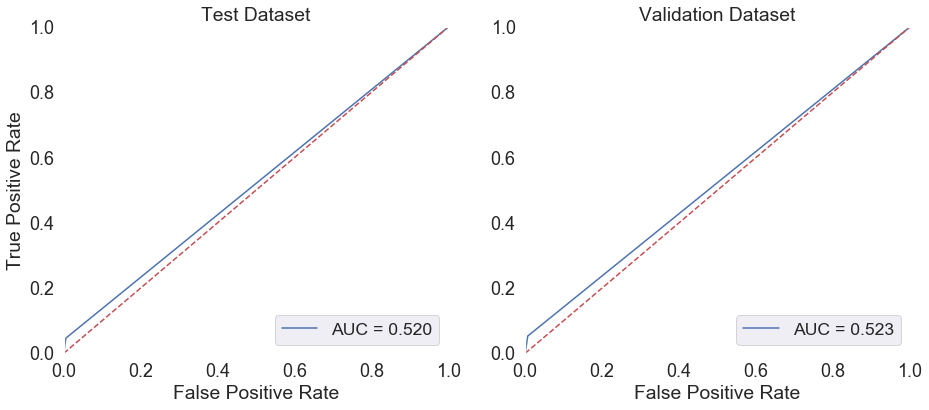

In [37]:
# Clear plots.
plt.clf()

# Set plot and text sizes.
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 13, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

#============
# Test ROC curve
#============

# Create first subplot with a white background.
plt.subplot(1,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(test_fpr, test_tpr, 'b', label = 'AUC = %0.3f' % test_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#============
# Validation ROC curve
#============

# Create second subplot with a white background.
plt.subplot(1,2,2, fc='white')

# Set title.
plt.title('Validation Dataset')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(valid_fpr, valid_tpr, 'b', label = 'AUC = %0.3f' % valid_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('False Positive Rate')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.3)

plt.show()